# Books corpus topic model

In [1]:
import pandas as pd
import numpy as np

friends = pd.read_csv('friends_text_ratings.csv', index_col=0)
friends.head()

,Year_of_prod,Season,Episode Number,Episode_Title,Duration,Summary,Director,Stars,Votes,match,text,len in words,len_prep
0,1994,1,1,The One Where Monica Gets a Roommate: The Pilot,22,"Monica and the gang introduce Rachel to the ""r...",James Burrows,8.3,7440,11,tell guy work going guy got wrong nice hump hu...,16424.0,5280.0
1,1994,1,2,The One with the Sonogram at the End,22,Ross finds out his ex-wife is pregnant. Rachel...,James Burrows,8.1,4888,12,guys understand kissing important need know ki...,10709.0,3170.0
2,1994,1,3,The One with the Thumb,22,Monica becomes irritated when everyone likes h...,James Burrows,8.2,4605,13,hi guys good walked subway said ouch said good...,12313.0,3689.0
3,1994,1,4,The One with George Stephanopoulos,22,Joey and Chandler take Ross to a hockey game t...,James Burrows,8.1,4468,14,omnipotent day want world peace hunger good th...,12290.0,4041.0
4,1994,1,5,The One with the East German Laundry Detergent,22,"Eager to spend time with Rachel, Ross pretends...",Pamela Fryman,8.5,4438,15,let big deal big deal amazing reach little man...,12660.0,3859.0


In [2]:
np.mean(friends['len_prep'])

4027.135593220339

## Some checks

In [3]:
# 5 least popular Friends episodes

check = friends.sort_values(by='Stars')

for i in range(5):
    row = check.iloc[i]
    episode = row['Episode Number']
    name = row['Episode_Title']
    season = row['Season']
    summary = row['Summary']
    stars = row['Stars']
    print(f'season {season} episode {episode} , "{name}" rating = {stars} stars: \n\n {summary}\n')

season 4 episode 21 , "The One with the Invitation" rating = 7.2 stars: 

 As Ross and Emily send out wedding invitations, he and Rachel each look back on their relationship together while Joey and Chandler look for a purpose in life.

season 6 episode 20 , "The One with Mac and C.H.E.E.S.E." rating = 7.4 stars: 

 Chandler forgets to write down a message for Joey when the time of his audition for the lead in a TV show is changed.

season 8 episode 19 , "The One with Joey's Interview" rating = 7.5 stars: 

 Joey prepares for his epic interview with Soap Opera Digest, reminiscing about his past acting experiences, his friends and his romantic life.

season 7 episode 21 , "The One with the Vows" rating = 7.5 stars: 

 Monica and Chandler are getting married in four weeks and have to write their vows, but neither has a clue what to say, so they reflect on their past.

season 9 episode 10 , "The One with Christmas in Tulsa" rating = 7.5 stars: 

 Chandler must spend Christmas in Tulsa, whi

In [4]:
# 5 most popular Friends episodes

check = friends.sort_values(by='Stars', ascending=False)

for i in range(5):
    row = check.iloc[i]
    episode = row['Episode Number']
    name = row['Episode_Title']
    season = row['Season']
    summary = row['Summary']
    stars = row['Stars']
    print(f'season {season} episode {episode} , "{name}" rating = {stars} stars: \n\n {summary}\n')

season 10 episode 18 , "The Last One: Part 2" rating = 9.7 stars: 

 Phoebe races Ross to the airport in a bid to stop Rachel from leaving for Paris. Monica and Chandler pack up their apartment ahead of their move to their new house, and Joey buys Chandler a new chick and duck as a leaving present.

season 5 episode 14 , "The One Where Everybody Finds Out" rating = 9.7 stars: 

 When Phoebe finds out about Monica and Chandler, she and Rachel attempt to get them to confess their relationship.

season 10 episode 17 , "The Last One: Part 1" rating = 9.5 stars: 

 Erica gives birth to the baby that Monica and Chandler are adopting. However, there's one small added surprise. Meanwhile, Ross and Rachel sleep together one last time before Rachel leaves ...                See full summary »

season 4 episode 12 , "The One with the Embryos" rating = 9.5 stars: 

 Phoebe's uterus is examined for implantation of the embryos. Meanwhile, a seemingly harmless game between Chandler and Joey against M

## prep

In [5]:
import glob
import random
RND = 12345
random.seed(RND)

class Chunker(object):
    def __init__(self, filenames, metadata, singles_only=False,
                 max_chars_per_book=None, chunk_size=None):
        
        # maximum number of characters to read from the beginning of each book:
        self.max_chars_per_book = max_chars_per_book
        
        # size of the chunks returned (in tokens):
        self.chunk_size = chunk_size
        
        # only return chunks from these files:
        self.filenames = filenames
        
        # include a dictionary with metadata:
        self.meta = meta
        
        # only return texts with a single genre label:
        self.singles_only = singles_only
        
        # only collect genres during the first iteration
        self.first = True

    def __iter__(self):
        if self.first:
            self.genres = []
        
        for filename in self.filenames:
            title = os.path.basename(filename)
            current_genres = self.meta[title]
            
            if self.singles_only:
                if len(current_genres) > 1:
                    continue

            with open(filename, 'r', encoding='utf-8') as f:
                try:
                    if self.max_chars_per_book:
                        text = f.read()
                        text = text[:self.max_chars_per_book]
                    else:
                        text = f.read()
                except:
                    continue
            
            tokens = text.split()
            
            for i in range(0, len(tokens), self.chunk_size):
                if self.first:
                    self.genres.append(current_genres)
                yield tokens[i:i + self.chunk_size]
                #this also helps for lazy loading because yield goes over it apart
        
        # stop collecting labels after first complete iteration
        self.first = False

In [6]:
n_features = 5000 # number of most common words
n_topics = 30 # number of topics
n_top_words = 60 # number of characteristic words per topic (viz purposes only)
max_df = 0.5 # maximum document frequency
min_df = 100 # minimum document frequency
max_books = 1000 # include all books (None), or a specific number
chunk_size = 4027  # length of the average friends episode (after keeping only ADJ, NOUN & VERB)

In [7]:
path = '../session-09-20220505T113620Z-001/session-09/hp_topic_model/books/books/*.txt'
filenames = sorted(list(glob.glob(path)))
print(len(filenames))

6800


In [8]:
random.seed(RND)
random.shuffle(filenames)
# print(filenames[:10])
# print(len(filenames))

In [9]:
import json
with open('../session-09-20220505T113620Z-001/session-09/hp_topic_model/books_meta.json', 'r') as f:
    meta = json.loads(f.read())

# for book, genres in list(meta.items())[:20]:
#     print(f"{book} -> {' - '.join(sorted(genres))}")

## NMF

In [8]:
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def identity(x):
    return x

chunks = Chunker(filenames, meta,
                 chunk_size=chunk_size,
                 max_chars_per_book=None)


vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df,
                             max_features=n_features,
                             analyzer=identity)
X = vectorizer.fit_transform(chunks)

from sklearn.decomposition import NMF
nmf = NMF(n_components=300,
          random_state=RND,
          verbose=1, max_iter=50).fit(X) # fit NMF model with TF-IDF features

violation: 1.0
violation: 0.04629373329002042
violation: 0.09600155080854965
violation: 0.14920749493784627
violation: 0.17036165113189883
violation: 0.16068439977194568
violation: 0.14152500824220748
violation: 0.12760548584663678
violation: 0.11349210676108205
violation: 0.10006058244600424
violation: 0.0866345171043539
violation: 0.07123933561119812
violation: 0.058822979374625516
violation: 0.04988421697517756
violation: 0.04374135652701329
violation: 0.038619079188683396
violation: 0.034582823425966414
violation: 0.03148809875548201
violation: 0.028955942429995787
violation: 0.02694358333043009
violation: 0.025323449374616364
violation: 0.02410231904395669
violation: 0.02285818065885852
violation: 0.02184666752979616
violation: 0.020735677502636954
violation: 0.01972831808291882
violation: 0.01887699968288961
violation: 0.018086824432456065
violation: 0.01735756400132959
violation: 0.01675669058999027
violation: 0.016191567036764755
violation: 0.015614574580153173
violation: 0.015

c:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 50 reached. Increase it to improve convergence.
  warnings.warn(


In [13]:
for topic_idx, topic in enumerate(nmf.components_[:10]):
    top_idxs = np.argsort(topic)[::-1][:10]
    top_words = np.array(vectorizer.get_feature_names())[top_idxs]
    print(f'topic {topic_idx}:', ' - '.join(top_words))

topic 0: relationship - feelings - weekend - upset - wanting - emotions - admit - dinner - decision - figured
topic 1: walks - starts - takes - puts - turns - pulls - gets - grabs - goes - opens
topic 2: vampire - fangs - scent - bite - centuries - stake - feed - hunger - hunter - wrist
topic 3: begins - turns - feels - takes - sees - sits - stands - thinks - tells - reaches
topic 4: vampires - vampire - stake - hunters - supernatural - fangs - attack - daylight - members - bitten
topic 5: rifle - rifles - fired - bullet - guns - bullets - firing - weapons - shots - yards
topic 6: mom - hug - honey - dinner - boyfriend - driveway - sweetie - homework - weird - hugged
topic 7: ship - hatch - vessel - cargo - ships - board - controls - pilot - port - engines
topic 8: horse - saddle - reins - riding - ride - rode - mount - stables - stable - animal
topic 9: baby - pregnant - pregnancy - babies - birth - belly - labor - born - appointment - honey


c:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
# chunks = Chunker(filenames, meta,
#                  singles_only=True,
#                  chunk_size=chunk_size,
#                  max_chars_per_book=None)
# X = vectorizer.transform(chunks)
# X = transformer.transform(X)
print(X.shape)

(25435, 5000)


In [15]:
nmf.verbose = 1
X_ = nmf.transform(X)
print(X_.shape)

violation: 1.0
violation: 0.4068495416898077
violation: 0.26144463366370774
violation: 0.10881991589958595
violation: 0.024994516881628764
violation: 0.014316590730076269
violation: 0.007152949374342622
violation: 0.0026865872334242914
violation: 0.0012043123889077566
violation: 0.0006614524767701214
violation: 0.0003361011069448299
violation: 0.0001478503416546271
violation: 6.914431204161371e-05
Converged at iteration 14
(25435, 300)


In [16]:
from sklearn.feature_selection import f_classif

genres = [g[0] for g in chunks.genres]
feature_names = vectorizer.get_feature_names()

for genre in set(genres):
    print(f'-> genre {genre}:')
    y = [1 if g == genre else 0 for g in genres]
    # univariate feature selection with F-test for feature scoring
    F, pval = f_classif(X_, y)
    
    # indices of three best topics
    for topic_idx in np.argsort(F)[::-1][:3]:
        topic = np.nan_to_num(nmf.components_[topic_idx])
        words = [feature_names[i] for i in topic.argsort()[:-10:-1]]
        print('   ' + ' - '.join(words))

c:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


-> genre Vampires:
   vampire - fangs - scent - bite - centuries - stake - feed - hunger - hunter
   vampires - vampire - stake - hunters - supernatural - fangs - attack - daylight - members
   mortal - immortal - murmured - mortals - muttered - dryly - assured - admitted - frowned
-> genre Literature:
   universe - science - reality - existence - nature - knowledge - consciousness - history - future
   author - writing - novel - write - writer - fiction - stories - published - characters
   song - music - guitar - sing - songs - singing - piano - sang - played
-> genre Young_Adult:
   stare - gives - shakes - glance - feels - leans - shake - nod - takes
   walks - starts - takes - puts - turns - pulls - gets - grabs - goes
   begins - turns - feels - takes - sees - sits - stands - thinks - tells
-> genre Thriller:
   government - country - military - president - american - nation - political - countries - citizens
   lawyer - client - lawyers - law - clients - attorney - firm - file -

In [17]:
import pandas as pd
nmf.verbose = 0

texts = [value.split() for value in friends.text.values]

scores = nmf.transform(vectorizer.transform(texts))  # transform the HP chapters according to the fitted NMF model
scores.shape
# print(scores)

[[0.         0.03484937 0.         ... 0.         0.00081062 0.00722832]
 [0.00782979 0.01999374 0.         ... 0.         0.0003767  0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.0060018  0.00359418 0.         ... 0.00041112 0.00731179 0.        ]
 [0.         0.         0.         ... 0.         0.00164281 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [18]:
df_scores = pd.DataFrame(scores, columns=[f't{i+1}' for i in range(scores.shape[1])])
friends2 = friends.join(df_scores)
friends2.head()

,Year_of_prod,Season,Episode Number,Episode_Title,Duration,Summary,Director,Stars,Votes,match,...,t291,t292,t293,t294,t295,t296,t297,t298,t299,t300
0,1994,1,1,The One Where Monica Gets a Roommate: The Pilot,22,"Monica and the gang introduce Rachel to the ""r...",James Burrows,8.3,7440,11,...,0.0,0.001308,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000811,0.007228
1,1994,1,2,The One with the Sonogram at the End,22,Ross finds out his ex-wife is pregnant. Rachel...,James Burrows,8.1,4888,12,...,0.0,0.000000,0.000377,0.000000,0.0,0.0,0.0,0.000000,0.000377,0.000000
2,1994,1,3,The One with the Thumb,22,Monica becomes irritated when everyone likes h...,James Burrows,8.2,4605,13,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,1994,1,4,The One with George Stephanopoulos,22,Joey and Chandler take Ross to a hockey game t...,James Burrows,8.1,4468,14,...,0.0,0.013545,0.000000,0.005333,0.0,0.0,0.0,0.000000,0.004276,0.000000
4,1994,1,5,The One with the East German Laundry Detergent,22,"Eager to spend time with Rachel, Ross pretends...",Pamela Fryman,8.5,4438,15,...,0.0,0.006093,0.000000,0.000464,0.0,0.0,0.0,0.000259,0.002814,0.000000


In [19]:
from operator import itemgetter
from scipy.stats import kendalltau

ranks = range(1, len(friends2.index)+1)
tau_scores = []
for col in [f't{i+1}' for i in range(scores.shape[1])]:
    tau, p = kendalltau(ranks, friends2[col].tolist())
    tau_scores.append((col, tau))
    
tau_scores.sort(key=itemgetter(1))
nb = 6
top, bottom = tau_scores[:nb], tau_scores[-nb:]
print(tau_scores[:10]) # print 10 topics with lowest Tau score

[('t156', -0.16165380866897655), ('t200', -0.1545603429182612), ('t240', -0.15076285897819725), ('t140', -0.1374889760761255), ('t245', -0.13579647279788934), ('t121', -0.13569458136377172), ('t123', -0.1347526285374056), ('t198', -0.13019134610251534), ('t251', -0.1266668624593103), ('t252', -0.10370471658580645)]


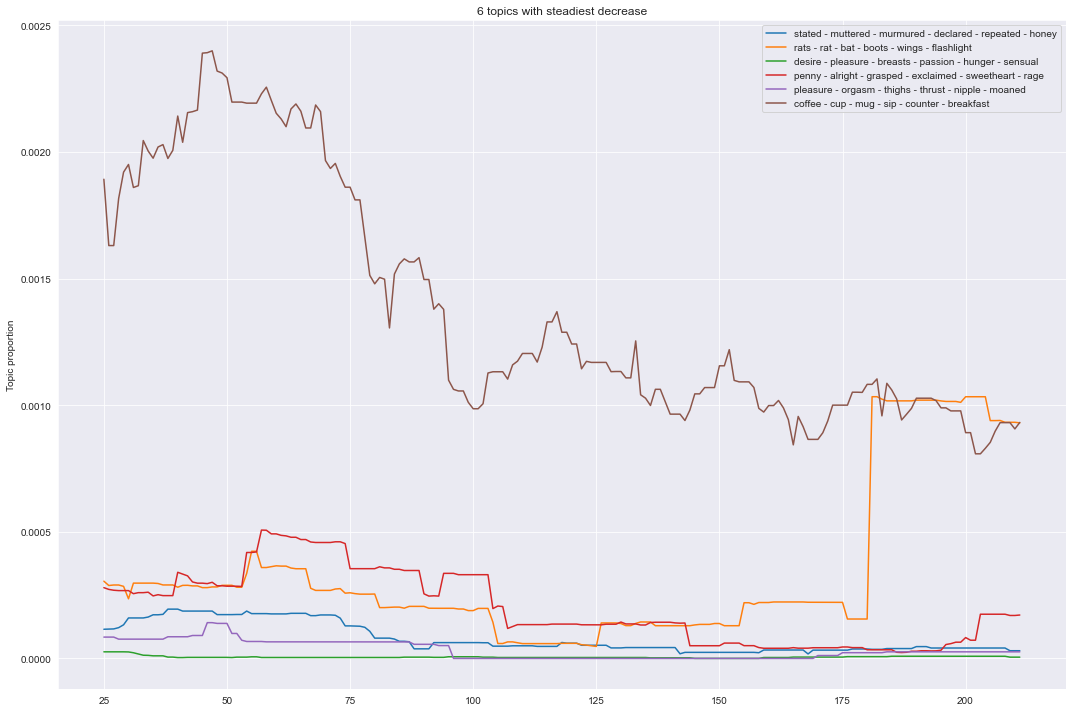

In [21]:
import matplotlib.pyplot as plt

import seaborn as sb
feature_names = vectorizer.get_feature_names_out()
fig = plt.figure(figsize=(15, 10))
sb.set_style("darkgrid")
for (feat, tau), col in zip(top, sb.color_palette("Set1")[:nb]):
    topic = nmf.components_[int(feat.replace('t', '')) - 1, :]
    words = [feature_names[i] for i in topic.argsort()[:-6-1:-1]]
    label = ' - '.join(words)
    friends2[feat].rolling(window=50, center=True).mean().plot(label=label)
plt.xlabel('', fontsize=10)
plt.ylabel('Topic proportion', fontsize=10)
plt.title(f'{nb} topics with steadiest decrease')
plt.tight_layout()
plt.legend();

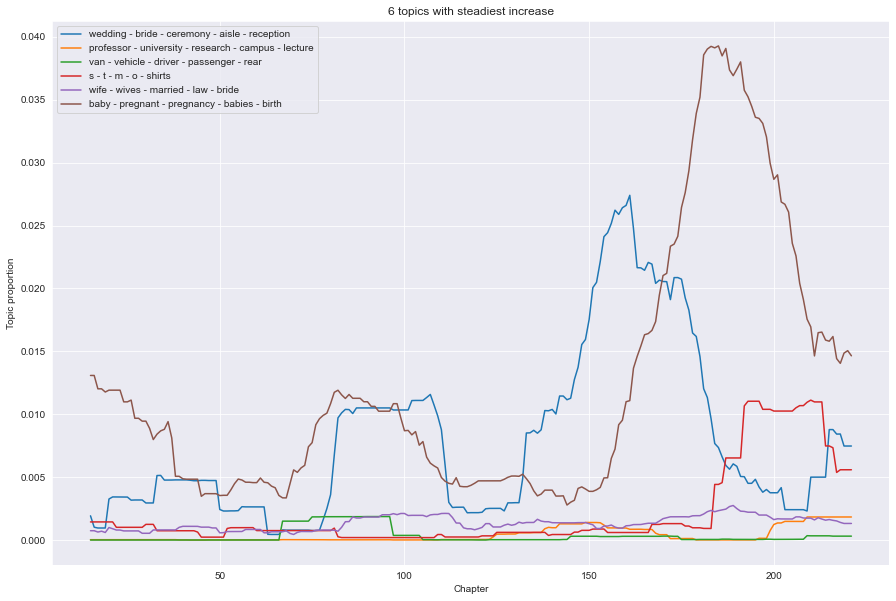

In [23]:
fig = plt.figure(figsize=(15, 10))
sb.set_style("darkgrid")
for (feat, tau), col in zip(bottom, sb.color_palette("Set1")[:nb]):
    topic = nmf.components_[int(feat.replace('t', '')) - 1, :]
    words = [feature_names[i] for i in topic.argsort()[:-5-1:-1]]
    label = ' - '.join(words)
    friends2[feat].rolling(window=30, center=True).mean().plot(label=label)
plt.xlabel('Chapter', fontsize=10)
plt.ylabel('Topic proportion', fontsize=10)
plt.title(f'{nb} topics with steadiest increase')
plt.legend();

In [38]:
#25 most predictive topics

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

feature_names = vectorizer.get_feature_names_out()
X = friends2.drop(columns=friends.columns.tolist())


y = friends2.Stars
# univariate feature selection with F-test for feature scoring
F, pval = f_regression(X, y)
    
    
for topic_idx in np.argsort(F)[::-1][:25]:
    topic = np.nan_to_num(nmf.components_[topic_idx])
    words = [feature_names[i] for i in topic.argsort()[:-10:-1]]
    print(f't{topic_idx}: ' + ' - '.join(words))

t260: plane - airport - flight - pilot - planes - jet - flying - fly - crash
t229: twins - twin - babies - pregnant - identical - pregnancy - born - tower - birth
t84: cody - frowns - race - roman - mobile - telephone - views - planes - grinned
t136: clan - chamber - courtyard - hall - leader - chief - land - leaders - herd
t164: summer - college - winter - candy - weekend - spring - month - spend - senior
t221: boss - company - assistant - contract - interview - suit - employees - employee - college
t30: author - writing - novel - write - writer - fiction - stories - published - characters
t47: beach - sand - ocean - waves - shore - vacation - shorts - swim - board
t227: store - counter - grocery - shopping - mall - stores - register - customers - parking
t159: camera - video - screen - cameras - tape - film - tv - studio - television
t110: river - bank - shore - current - banks - fish - mud - waters - west
t99: prison - prisoners - prisoner - jail - trial - gang - escape - bars - dru

### Predictions 
#### setting baseline

In [46]:
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X = friends2.drop(columns=friends.columns.tolist())
y = friends2.Stars

dummy_regr = DummyRegressor(strategy="mean")

scores = cross_val_score(dummy_regr, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores))


-0.3946868469935892


#### predictions with topics

In [54]:
#all features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

feature_names = vectorizer.get_feature_names_out()
X = friends2.drop(columns=friends.columns.tolist())
y = friends2.Stars

reg = LinearRegression()

scores = cross_val_score(reg, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores))

-168785267634.5802


In [57]:
#25 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:25]]

feature_names = vectorizer.get_feature_names_out()
Xble = friends2.drop(columns=friends.columns.tolist())
X = Xble[Best]
y = friends2.Stars

reg = LinearRegression()
scal = StandardScaler()

pipe = make_pipeline(reg, scal)

scores = cross_val_score(reg, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores))

-0.4614957939830687


In [58]:
#10 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:10]]

feature_names = vectorizer.get_feature_names_out()
Xble = friends2.drop(columns=friends.columns.tolist())
X = Xble[Best]
y = friends2.Stars

reg = LinearRegression()
scal = StandardScaler()

pipe = make_pipeline(reg, scal)

scores = cross_val_score(reg, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores))

-0.4194487685914556


In [59]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:5]]

feature_names = vectorizer.get_feature_names_out()
Xble = friends2.drop(columns=friends.columns.tolist())
X = Xble[Best]
y = friends2.Stars

reg = LinearRegression()
scal = StandardScaler()

pipe = make_pipeline(reg, scal)

scores = cross_val_score(reg, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores))

-0.4124271300691623


In [71]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:10]]
xtra = ['Year_of_prod', 'Votes', 'Duration']

cols = Best+xtra

cols.append('Stars')

scal = StandardScaler()

corrM = friends2[cols].corr()
 
corrM


,t260,t229,t84,t136,t164,t221,t30,t47,t227,t159,Year_of_prod,Votes,Duration,Stars
t260,1.000000,-0.032373,-0.033849,-0.051790,0.008305,0.059966,-0.074678,0.149145,0.016131,-0.019844,0.061369,-0.100354,-0.020806,-0.060883
t229,-0.032373,1.000000,-0.034273,0.018762,0.056593,-0.057698,0.017961,-0.035259,-0.047518,-0.043157,-0.080505,0.024162,-0.058802,-0.018253
t84,-0.033849,-0.034273,1.000000,-0.011527,-0.029453,-0.038423,-0.026220,0.084953,-0.055101,0.028558,-0.030762,0.050811,-0.029831,0.048243
t136,-0.051790,0.018762,-0.011527,1.000000,0.110852,-0.002671,-0.026905,-0.041531,-0.019128,0.221905,0.049393,0.021739,-0.030610,0.083991
t164,0.008305,0.056593,-0.029453,0.110852,1.000000,-0.067725,0.047955,-0.002137,0.118341,-0.016035,0.011394,-0.055467,-0.049909,-0.032466
t221,0.059966,-0.057698,-0.038423,-0.002671,-0.067725,1.000000,-0.022057,0.008690,-0.097072,-0.070136,0.084668,-0.107340,0.260708,-0.000776
t30,-0.074678,0.017961,-0.026220,-0.026905,0.047955,-0.022057,1.000000,-0.037909,0.010682,-0.027001,0.033819,-0.059496,-0.044233,-0.056105
t47,0.149145,-0.035259,0.084953,-0.041531,-0.002137,0.008690,-0.037909,1.000000,0.017259,0.011442,0.043256,0.006895,0.022485,0.017231
t227,0.016131,-0.047518,-0.055101,-0.019128,0.118341,-0.097072,0.010682,0.017259,1.000000,-0.049078,0.001980,0.052244,-0.055859,-0.015973
t159,-0.019844,-0.043157,0.028558,0.221905,-0.016035,-0.070136,-0.027001,0.011442,-0.049078,1.000000,0.112016,-0.064804,-0.029728,0.047803


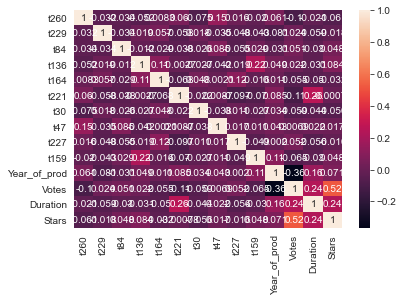

In [72]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(corrM, annot=True)
plt.show()

In [74]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:10]]
xtra = ['Year_of_prod', 'Votes', 'Duration']

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = LinearRegression()
scal = StandardScaler()

pipe = make_pipeline(scal,reg)

scores = cross_val_score(pipe, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores))

-0.367107509760561


In [75]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:10]]
xtra = ['Year_of_prod', 'Duration']

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = LinearRegression()
scal = StandardScaler()

pipe = make_pipeline(scal,reg)

scores = cross_val_score(pipe, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores))

-0.419705167218397


In [ ]:
xtra = ['Year_of_prod', 'Director', 'Votes', 'Duration']
test
from sklearn.compose import ColumnTransformer

In [31]:
import joblib
filename = 'nmf_books_friends.sav'
joblib.dump(nmf, filename)

['nmf_books_friends.sav']

## LDA